In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.tree import ExtraTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.tree  import DecisionTreeRegressor

In [2]:
def load_data(url):
    data = pd.read_csv(url)
    return data

In [3]:
train = load_data(r'C:\Users\85402\Desktop\bike\train.csv')    #还要再分成dev和train两部分，用于验证模型
test = load_data(r'C:\Users\85402\Desktop\bike\test.csv')
sample_submit = load_data(r'C:\Users\85402\Desktop\bike\sample_submit.csv') #看一看提交的形式

In [4]:
test.head(5)       #看一下test是否异常

,id,city,hour,is_workday,weather,temp_1,temp_2,wind
0,10001,0,1,1,1,20.7,20.6,0
1,10002,1,18,0,1,32.4,36.0,1
2,10003,1,16,1,1,27.6,26.9,4
3,10004,1,11,0,1,9.3,9.4,0
4,10005,0,10,1,2,24.8,26.9,2


In [5]:
test_id = test.loc[:,["id"]]    #取出id
test_id.shape                   

(7000, 1)

In [6]:
train.info(null_counts=True)              #无缺失不需要填充


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
id            10000 non-null int64
city          10000 non-null int64
hour          10000 non-null int64
is_workday    10000 non-null int64
weather       10000 non-null int64
temp_1        10000 non-null float64
temp_2        10000 non-null float64
wind          10000 non-null int64
y             10000 non-null int64
dtypes: float64(2), int64(7)
memory usage: 703.2 KB


In [7]:
test.info(null_counts=True)                     #无缺失，不需要填充

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
id            7000 non-null int64
city          7000 non-null int64
hour          7000 non-null int64
is_workday    7000 non-null int64
weather       7000 non-null int64
temp_1        7000 non-null float64
temp_2        7000 non-null float64
wind          7000 non-null int64
dtypes: float64(2), int64(6)
memory usage: 437.6 KB


In [8]:
train_X,dev_X,train_Y,dev_Y = train_test_split(train.iloc[:,:-1],train.iloc[:,-1],random_state=0,test_size=0.1)

探索性分析环节

In [9]:
train_Y = pd.DataFrame({"y":train_Y})    #取出y
dev_Y = pd.DataFrame({"y":dev_Y})

In [10]:
train_data = pd.concat([train_X,train_Y],axis=1)      #合一下
train_data.head(5)

,id,city,hour,is_workday,weather,temp_1,temp_2,wind,y
1554,1555,1,11,0,3,23.3,25.3,2,58
2087,2088,0,14,1,1,29.4,32.8,0,62
5470,5471,1,19,0,2,27.1,28.3,0,97
2363,2364,0,16,1,1,30.3,33.8,1,102
7570,7571,1,15,1,1,27.0,28.2,0,63


In [11]:
train_data.describe()

,id,city,hour,is_workday,weather,temp_1,temp_2,wind,y
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4992.049333,0.501111,11.512889,0.685556,1.426000,15.239911,15.300011,1.247222,50.331778
std,2888.563142,0.500027,6.944804,0.464320,0.635708,9.012280,11.302209,1.093523,47.830110
min,1.000000,0.000000,0.000000,0.000000,1.000000,-7.600000,-15.600000,0.000000,0.000000
25%,2487.750000,0.000000,6.000000,0.000000,1.000000,7.800000,5.800000,0.000000,10.000000
50%,4985.500000,1.000000,12.000000,1.000000,1.000000,15.600000,16.000000,1.000000,38.000000
75%,7495.250000,1.000000,18.000000,1.000000,2.000000,22.500000,24.800000,2.000000,74.000000
max,10000.000000,1.000000,23.000000,1.000000,4.000000,38.600000,46.800000,7.000000,249.000000


看这个气温上下限可能是南方城市，可以按照气温来划分四季

In [12]:
print("城市0的最高温是：",train_data[train_data["city"]==0]["temp_1"].max())
print("城市0的最低温是：",train_data[train_data["city"]==0]["temp_1"].min())

print("城市1的最高温是：",train_data[train_data["city"]==1]["temp_1"].max())
print("城市1的最低温是：",train_data[train_data["city"]==1]["temp_1"].min())

城市0的最高温是： 38.6
城市0的最低温是： -7.6
城市1的最高温是： 37.2
城市1的最低温是： -7.6


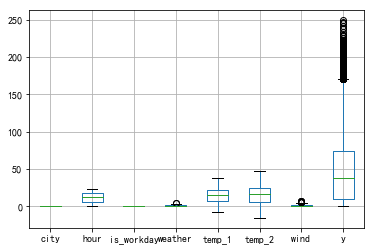

In [13]:
train_data.drop(["id"],axis=1).boxplot()

In [14]:
#看来那几个离群点什么情况
train_data[train_data["wind"] > 5]

,id,city,hour,is_workday,weather,temp_1,temp_2,wind,y
4688,4689,0,21,1,1,11.4,11.7,7,38
3063,3064,0,12,1,1,17.2,17.8,6,71
8044,8045,0,13,1,1,14.8,15.2,6,76
1982,1983,0,15,1,1,21.7,24.6,6,46
1545,1546,0,3,0,2,-3.7,-13.4,6,3
1245,1246,0,23,1,1,10.1,10.2,6,21
5903,5904,1,1,1,1,6.2,0.1,6,1
3346,3347,1,18,0,3,29.2,32.6,7,54
833,834,1,17,1,1,6.5,1.5,6,56
6598,6599,1,17,0,3,22.1,22.0,7,4


In [15]:
train_data[train_data["weather"] == 4] 



,id,city,hour,is_workday,weather,temp_1,temp_2,wind,y
8172,8173,0,18,1,4,1.0,-1.4,0,41
7331,7332,0,1,0,4,-1.6,-7.2,1,5


Text(0,0.5,'时段')

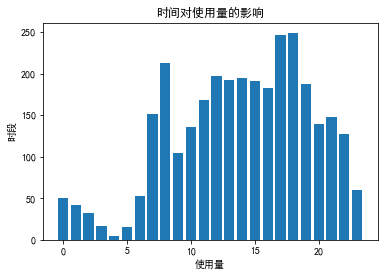

In [16]:
plt.bar(train_data["hour"],train_data["y"])    #各个时间的骑车分布
plt.title("时间对使用量的影响")
plt.xlabel("使用量")
plt.ylabel("时段")

可以看到凌晨4点最少人用，7、8点上班高峰，午饭时间也是，傍晚5、6点最多人用，符合常理，时间段是一个重要影响。
可以考考虑把高于上午七点的时段定义为高峰期，1表示

Text(0,0.5,'使用量')

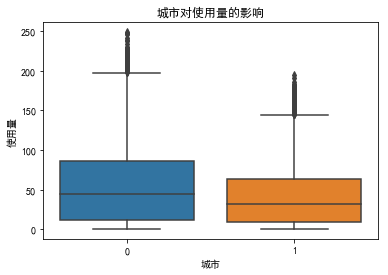

In [17]:
#不同的城市由于地形，气候等等也会影响骑车的积极性
sns.boxplot(x=train_data["city"],y=train_data["y"])    #各个城市的骑车分布 ,明显的0号城市更加热衷于骑自行车
plt.title("城市对使用量的影响")
plt.xlabel("城市")
plt.ylabel("使用量")

不由得很好奇，两个城市的使用量高峰是否有所不同？

Text(0.5,1,'两个城市的使用量比较')

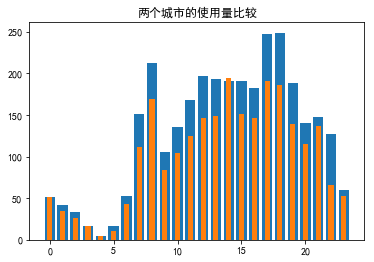

In [18]:
c_0 = train_data[train_data["city"] == 0]


c_1 = train_data[train_data["city"] == 1]

plt.bar(c_0["hour"],c_0["y"],width=0.8)

plt.bar(c_1["hour"],c_1["y"],width = 0.4)
plt.title("两个城市的使用量比较")

可以看到他们大致是相同的，可能城市0更加多人导致每个时段的使用量都高一点

Text(0,0.5,'使用量')

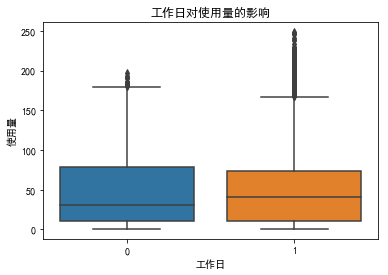

In [19]:
sns.boxplot(x=train_data["is_workday"],y=train_data["y"])   #工作日使用单车更多，说明大家主要用于通勤
plt.title("工作日对使用量的影响")
plt.xlabel("工作日")
plt.ylabel("使用量")

Text(0,0.5,'使用量')

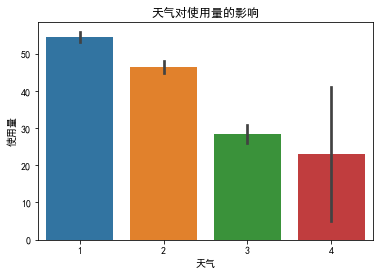

In [20]:
sns.barplot(x=train_data["weather"],y=train_data["y"])  
plt.title("天气对使用量的影响")
plt.xlabel("天气")
plt.ylabel("使用量")

1为晴朗，2为多云、阴天，3为轻度降水天气，4为强降水天气,随着天气逐渐恶劣，单车的使用也逐渐减小

接下来看看气温和体感温度的影响

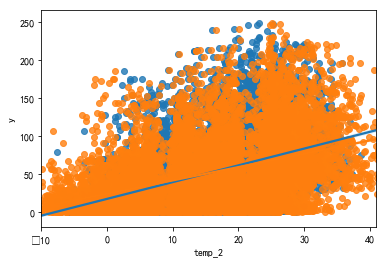

In [21]:
sns.regplot(x=train_data["temp_1"],y=train_data["y"])
sns.regplot(x=train_data["temp_2"],y=train_data["y"])

几乎就是重合的啊，说明两个气温之间的多重共线性应该挺严重的。。。。单车使用基本都在10-35左右的区间为主，太热太冷都少人起，经过查阅资料发现，由于体感温度是由气温以及风速计算得出的，所以体感温度已经包含了气温，以及一部分的风速信息，与现有的风力等级可以能会存在一些线性关系，考虑删掉体感温度。

此外，两个温度对使用量的影响也很明显，在不反人类的区间内，气温越高，使用越多

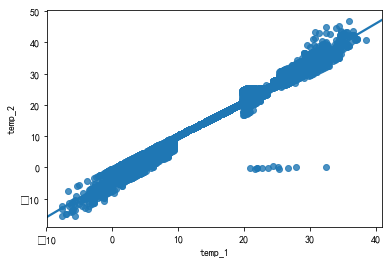

In [22]:
sns.regplot(x=train_data["temp_1"],y=train_data["temp_2"])   #两个气温之间确实多重共线性

Text(0,0.5,'使用量')

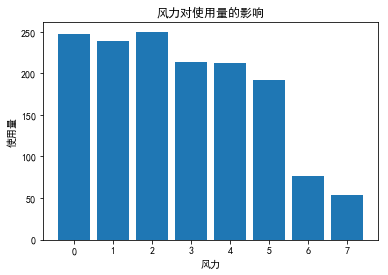

In [23]:
#接下来考察风力对使用量的影响，以及风力对气温的影响。
plt.bar(train_data["wind"],train_data["y"])  
plt.title("风力对使用量的影响")
plt.xlabel("风力")
plt.ylabel("使用量")

三级开始会有些微影响，六级开始风力巨大影响

Text(0,0.5,'气温')

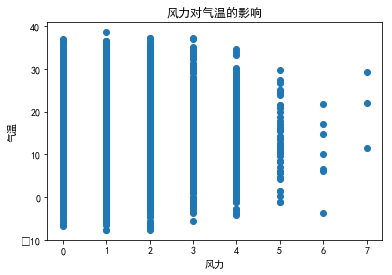

In [24]:
plt.scatter(train_data["wind"],train_data["temp_1"])  
plt.title("风力对气温的影响")
plt.xlabel("风力")
plt.ylabel("气温")

Text(0,0.5,'体感温度')

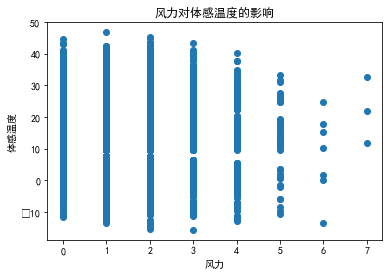

In [25]:
plt.scatter(train_data["wind"],train_data["temp_2"])  
plt.title("风力对体感温度的影响")
plt.xlabel("风力")
plt.ylabel("体感温度")

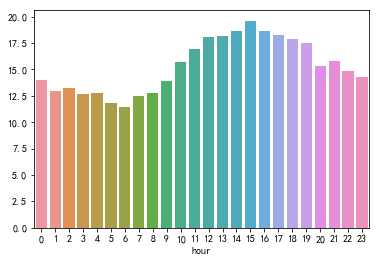

In [26]:
#时间对体感温度的影响
sns.barplot(train_X.groupby(["hour"]).mean()["temp_2"].index,train_X.groupby(["hour"]).mean()["temp_2"].values)

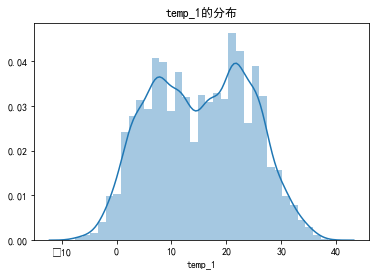

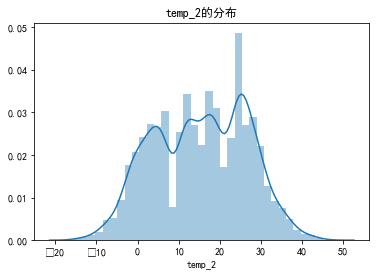

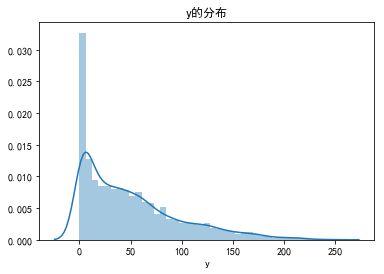

In [27]:
for i in ["temp_1","temp_2","y"]:
    sns.distplot(train_data[i])
    plt.title(i+"的分布")
    plt.show()

都不是正态分布。

In [28]:
print(train_data["y"].skew())
print(train_data["y"].kurt())

1.1622863589865795
0.9167852339082492


                  id      city      hour  is_workday   weather    temp_1  \
id          1.000000  0.021696  0.012588    0.011467  0.000239 -0.008814   
city        0.021696  1.000000  0.005884    0.003898  0.022632 -0.055042   
hour        0.012588  0.005884  1.000000    0.018901 -0.027345  0.134477   
is_workday  0.011467  0.003898  0.018901    1.000000  0.034854  0.054798   
weather     0.000239  0.022632 -0.027345    0.034854  1.000000 -0.102270   
temp_1     -0.008814 -0.055042  0.134477    0.054798 -0.102270  1.000000   
temp_2     -0.008528 -0.052855  0.133224    0.053970 -0.105228  0.988271   
wind       -0.013097  0.005086  0.125003    0.003423  0.027998 -0.008358   
y          -0.002136 -0.157726  0.405485    0.034090 -0.148379  0.416803   

              temp_2      wind         y  
id         -0.008528 -0.013097 -0.002136  
city       -0.052855  0.005086 -0.157726  
hour        0.133224  0.125003  0.405485  
is_workday  0.053970  0.003423  0.034090  
weather    -0.105228  0.

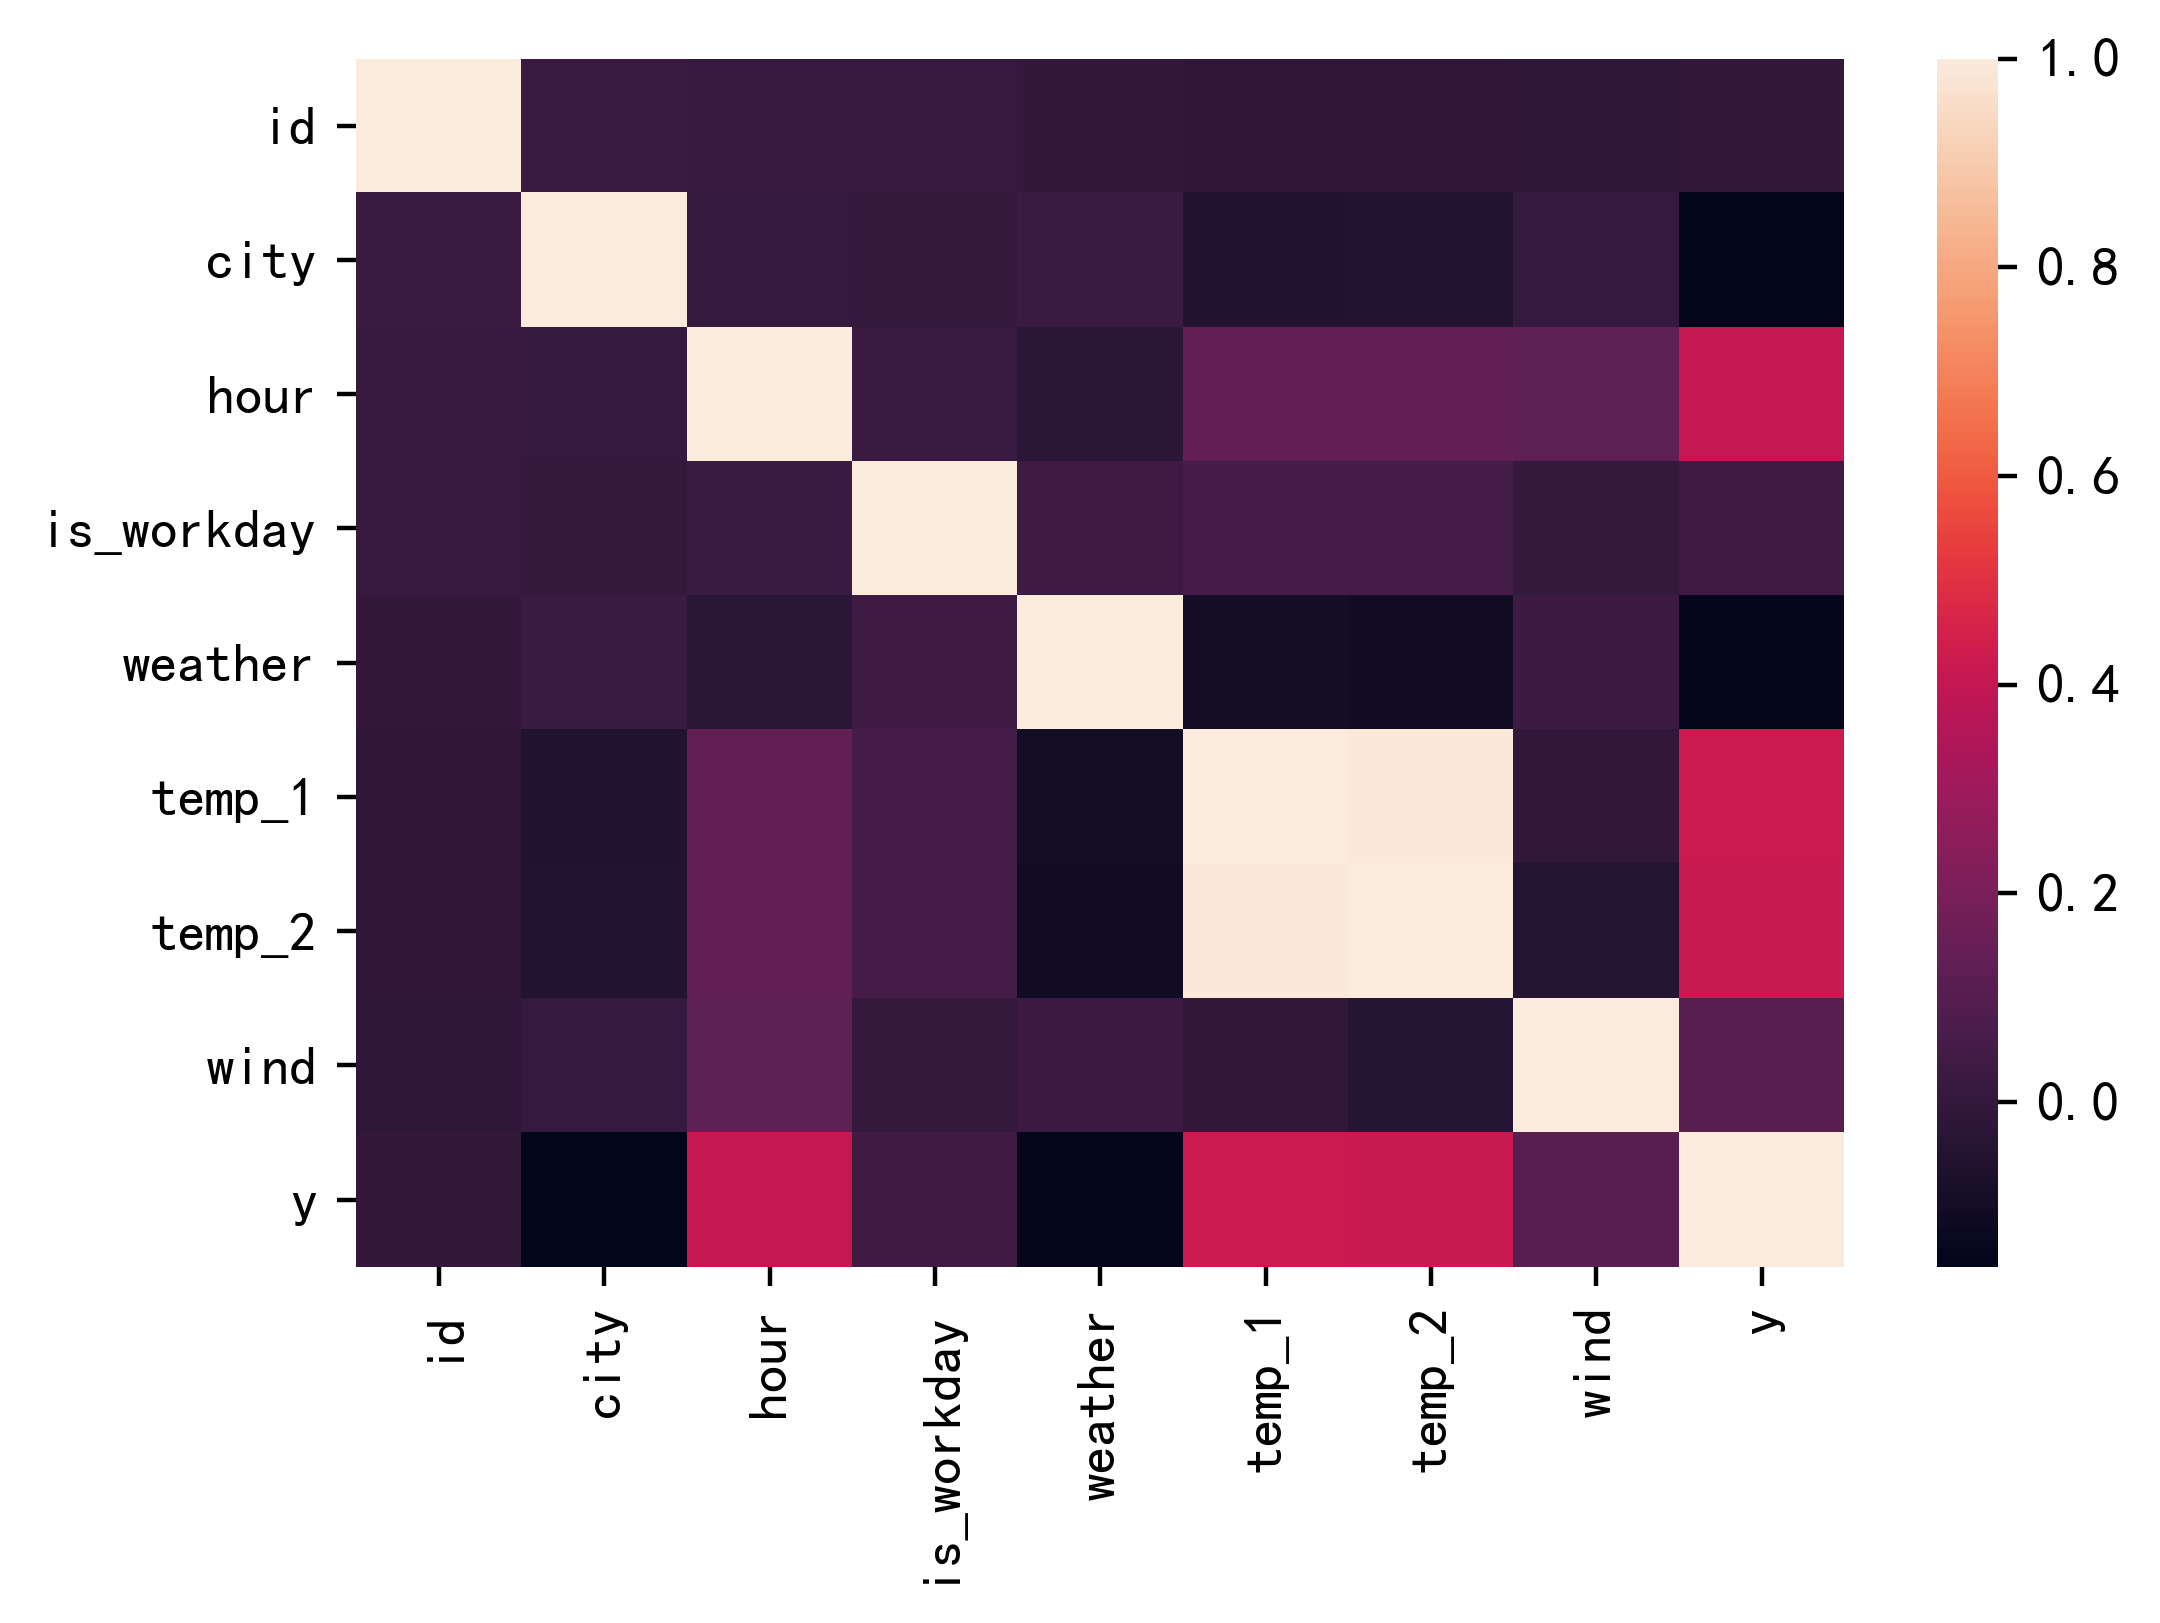

In [29]:
plt.figure(dpi=400)
cor_mat = train_data.corr()
print(cor_mat)
sns.heatmap(cor_mat)

In [30]:
train_data.var()  #再看看方差

id            8.343797e+06
city          2.500265e-01
hour          4.823030e+01
is_workday    2.155931e-01
weather       4.041245e-01
temp_1        8.122119e+01
temp_2        1.277399e+02
wind          1.195792e+00
y             2.287719e+03
dtype: float64

看起来也没有异常值，不太需要处理。

注意到上面有些离散型特征例如风力，天气等，他们的一些取值如风力6级，7级数量很少，考虑把他们合并，下面详细考察

<BarContainer object of 24 artists>

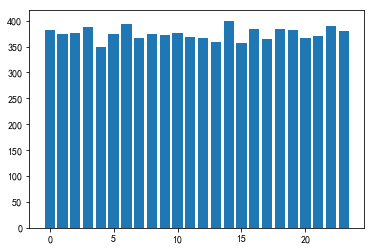

In [31]:
plt.bar(x=train_data["hour"].value_counts().index,height=train_data["hour"].value_counts())  #各个时间端分布均匀

<BarContainer object of 4 artists>

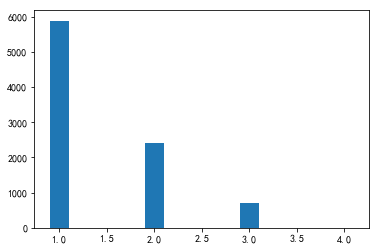

In [32]:
plt.bar(x=train_data["weather"].value_counts().index,height=train_data["weather"].value_counts(),width=0.2)  #各个时间端分布均匀

天气四只有两个，考虑把他们和天气三合并，改为期望值

<BarContainer object of 8 artists>

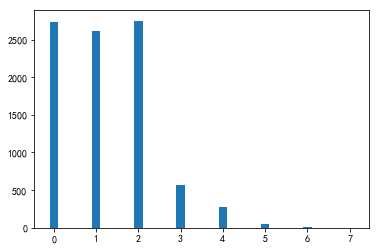

In [33]:
plt.bar(x=train_data["wind"].value_counts().index,height=train_data["wind"].value_counts(),width=0.2)

考虑天气5，6，7合并,改为期望值

In [34]:
def encode(data):
    #合并天气，风力，定义把各个时间段划分为高峰，半高峰，非高峰，用2，1，0表示
    data["is_peak"] = 1
    
    for i in [8,17,18]:
        data.loc[data[data["hour"] == i].index,["is_peak"]] = 2
        
        
    for i in [0,1,2,3,4,5,6,23]:
        data.loc[data[data["hour"] == i].index,["is_peak"]] = 0
        
        
    
    data.loc[data[data["weather"] == 3].index,["weather"]] = 3.5
    data.loc[data[data["weather"] == 4].index,["weather"]] = 3.5
    

    
    data.loc[data[data["wind"] == 5].index,["wind"]] = 6
    data.loc[data[data["wind"] == 7].index,["wind"]] = 6
    
    
        
    data["is_warm"] = 1
    data.loc[data[data["temp_1"] < 10].index,["is_warm"]] = 1
    data.loc[data[(data["temp_1"] > 10) & (data["temp_1"] <= 20) ].index,["is_warm"]] = 2
    data.loc[data[(data["temp_1"] > 20) & (data["temp_1"] <= 30) ].index,["is_warm"]] = 3
    data.loc[data[data["temp_1"] > 30].index,["is_warm"]] = 4
             
 
    return data

In [35]:
train_X = encode(train_X)
dev_X = encode(dev_X)
test = encode(test)

In [36]:
def gen_feature(data):  #生成大量交叉特征，这里借用多项式回归的思想来构筑特征了
    a = ["city","hour","is_workday","weather","temp_1","wind","is_peak","is_warm"]
    for i in a:
        for j in a:
            if (a.index(i) <= a.index(j)):
                data["{}*{}".format(i,j)] = data[i] * data[j]
                data["{}+{}".format(i,j)] = data[i] + data[j]
                
    return data

In [37]:
train_X = gen_feature(train_X)
dev_X = gen_feature(dev_X)
test = gen_feature(test)

In [38]:
#由于城市并没有顺序，考虑使用独热编码
def one_hot(data):
    #独热编码
    data=pd.get_dummies(data,columns=["city"],prefix="city",prefix_sep="")   
    
    
    return data

In [39]:
#测试代码
train_X = one_hot(train_X)
dev_X = one_hot(dev_X)
test = one_hot(test)

In [40]:
def select_feature(data):
    data = data.drop(["id"],axis=1)
    return data

In [41]:
train_X = select_feature(train_X)
dev_X = select_feature(dev_X)
test = select_feature(test)

In [42]:
def scale(train_X,dev_X,test):
    scaler = StandardScaler().fit(train_X)
    train_X = scaler.transform(train_X)
    dev_X = scaler.transform(dev_X)
    test = scaler.transform(test)
    
    return train_X,dev_X,test

In [43]:
train_X,dev_X,test = scale(train_X,dev_X,test)

In [44]:
#def Pca(train_X,dev_X,test):
#    p = PCA(n_components=22).fit(train_X)
#    train_X = p.transform(train_X)
#    dev_X = p.transform(dev_X)
#    test = p.transform(test)
#    return  train_X,dev_X,test
#
#train_X,dev_X,test = Pca(train_X,dev_X,test)                 PCA反而会降低模型表现，不使用PCA

In [45]:
def GBDT(train_X,train_Y,dev_X,dev_Y,test,test_id):   #现在很好了
    mymodel = GradientBoostingRegressor(learning_rate=0.2,n_estimators=180,max_depth = 3,min_samples_split=4,min_samples_leaf=5,random_state=0)
    mymodel.fit(train_X,train_Y)
    
    pre_on_train = mymodel.predict(train_X)
    mse_t = mean_squared_error(train_Y,pre_on_train)
    print("训练集上的RMSE是:",np.sqrt(mse_t))
    
    pre_on_dev = mymodel.predict(dev_X)
    mse_d = mean_squared_error(dev_Y, pre_on_dev)
    print("dev集上的RMSE是：",np.sqrt(mse_d))
    
    sub = mymodel.predict(test)
    
    
    return sub,pre_on_train,pre_on_dev

In [46]:
def XGB(train_X,train_Y,dev_X,dev_Y,test,test_id):   #调好了
    mymodel = XGBRegressor(learning_rate=0.32,n_estimators=57,reg_lambda=205,max_depth=7,random_state=0)
    mymodel.fit(train_X,train_Y)
    
    pre_on_train = mymodel.predict(train_X)
    mse_t = mean_squared_error(train_Y,pre_on_train)
    print("训练集上的RMSE是:",np.sqrt(mse_t))
    
    pre_on_dev = mymodel.predict(dev_X)
    mse_d = mean_squared_error(dev_Y, pre_on_dev)
    print("dev集上的RMSE是：",np.sqrt(mse_d))
    
    sub = mymodel.predict(test)
    
    
    return sub,pre_on_train,pre_on_dev

In [47]:
def RF(train_X,train_Y,dev_X,dev_Y,test,test_id):
    
    
    mymodel = RandomForestRegressor(n_estimators=18,max_depth=12,min_samples_split=4,min_samples_leaf=6,random_state=0)
    mymodel.fit(train_X,train_Y)
    
    pre_on_train = mymodel.predict(train_X)
    mse_t = mean_squared_error(train_Y,pre_on_train)
    print("训练集上的RMSE是:",np.sqrt(mse_t))
    
    pre_on_dev = mymodel.predict(dev_X)
    mse_d = mean_squared_error(dev_Y, pre_on_dev)
    print("dev集上的RMSE是：",np.sqrt(mse_d))
    
    sub = mymodel.predict(test)
    
    
    return sub,pre_on_train,pre_on_dev

In [48]:
def ADB(train_X,train_Y,dev_X,dev_Y,test,test_id):
    
    
    mymodel = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,min_samples_split=4, min_samples_leaf=3,random_state=0), 
                                n_estimators=6,learning_rate=0.1,loss='square',random_state=0)
    mymodel.fit(train_X,train_Y)
    
    pre_on_train = mymodel.predict(train_X)
    mse_t = mean_squared_error(train_Y,pre_on_train)
    print("训练集上的RMSE是:",np.sqrt(mse_t))
    
    pre_on_dev = mymodel.predict(dev_X)
    mse_d = mean_squared_error(dev_Y, pre_on_dev)
    print("dev集上的RMSE是：",np.sqrt(mse_d))
    
    sub = mymodel.predict(test)
    
    
    return sub,pre_on_train,pre_on_dev

In [49]:
def LGBM(train_X,train_Y,dev_X,dev_Y,test,test_id):   #ok
    
    
    mymodel = LGBMRegressor(learning_rate=0.3,n_estimators=300,max_depth=4,reg_lambda=400,random_state=0)
    mymodel.fit(train_X,train_Y)
    
    pre_on_train = mymodel.predict(train_X)
    mse_t = mean_squared_error(train_Y,pre_on_train)
    print("训练集上的RMSE是:",np.sqrt(mse_t))
    
    pre_on_dev = mymodel.predict(dev_X)
    mse_d = mean_squared_error(dev_Y, pre_on_dev)
    print("dev集上的RMSE是：",np.sqrt(mse_d))
    
    sub = mymodel.predict(test)
    
    
    return sub,pre_on_train,pre_on_dev

In [50]:
def DTR(train_X,train_Y,dev_X,dev_Y,test,test_id,random_state=0):
    
    
    mymodel = DecisionTreeRegressor(min_samples_split=10, min_samples_leaf=18)
    mymodel.fit(train_X,train_Y)
    
    pre_on_train = mymodel.predict(train_X)
    mse_t = mean_squared_error(train_Y,pre_on_train)
    print("训练集上的RMSE是:",np.sqrt(mse_t))
    
    pre_on_dev = mymodel.predict(dev_X)
    mse_d = mean_squared_error(dev_Y, pre_on_dev)
    print("dev集上的RMSE是：",np.sqrt(mse_d))
    
    sub = mymodel.predict(test)
    
    
    return sub,pre_on_train,pre_on_dev

In [51]:
sub1,pre_on_train1,pre_on_dev1 = GBDT(train_X,train_Y,dev_X,dev_Y,test,test_id)

训练集上的RMSE是: 13.143714270182098
dev集上的RMSE是： 14.806728910967852


In [52]:
sub2,pre_on_train2,pre_on_dev2 = XGB(train_X,train_Y,dev_X,dev_Y,test,test_id)

[12:23:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
训练集上的RMSE是: 12.039548116695059
dev集上的RMSE是： 14.842062953713091


In [53]:
sub3,pre_on_train3,pre_on_dev3 = RF(train_X,train_Y,dev_X,dev_Y,test,test_id)

训练集上的RMSE是: 12.133056158287902
dev集上的RMSE是： 15.325455578228123


In [54]:
sub4,pre_on_train4,pre_on_dev4 = ADB(train_X,train_Y,dev_X,dev_Y,test,test_id)

训练集上的RMSE是: 12.895397190540121
dev集上的RMSE是： 17.14330098826163


In [55]:
sub5,pre_on_train5,pre_on_dev5 = LGBM(train_X,train_Y,dev_X,dev_Y,test,test_id)

训练集上的RMSE是: 12.591864837425216
dev集上的RMSE是： 15.109402707184643


In [56]:
sub6,pre_on_train6,pre_on_dev6 = DTR(train_X,train_Y,dev_X,dev_Y,test,test_id)

训练集上的RMSE是: 14.51769400001542
dev集上的RMSE是： 17.664515603537506


经过多次测试，只挑选这四个,GBDT,XGB和LGBM,RF

In [57]:
sub1 = pd.Series(sub1)
sub2 = pd.Series(sub2)
sub3 = pd.Series(sub3)
sub4 = pd.Series(sub4)
sub5 = pd.Series(sub5)
sub6 = pd.Series(sub6)
pre_on_train1 = pd.Series(pre_on_train1)
pre_on_train2 = pd.Series(pre_on_train2)
pre_on_train3 = pd.Series(pre_on_train3)
pre_on_train4 = pd.Series(pre_on_train4)
pre_on_train5 = pd.Series(pre_on_train5)
pre_on_train6 = pd.Series(pre_on_train6)
pre_on_dev1 = pd.Series(pre_on_dev1)
pre_on_dev2 = pd.Series(pre_on_dev2)
pre_on_dev3 = pd.Series(pre_on_dev3)
pre_on_dev4 = pd.Series(pre_on_dev4)
pre_on_dev5 = pd.Series(pre_on_dev5)
pre_on_dev6 = pd.Series(pre_on_dev6)

In [75]:
def LA(train_Y):   #最后再融合一次
    t_X = pd.concat([pre_on_train1,pre_on_train2,pre_on_train3,pre_on_train5],axis=1)
    

    mymodel =  Ridge(alpha=1200000)  
    mymodel.fit(t_X,train_Y)
    
    
    pre_on_train = mymodel.predict(t_X)
    mse_t = mean_squared_error(train_Y,pre_on_train)
    print("训练集上的RMSE是:",np.sqrt(mse_t))
    
    
    d_X = pd.concat([pre_on_dev1,pre_on_dev2,pre_on_dev3,pre_on_dev5],axis=1)
    pre_on_dev = mymodel.predict(d_X)
    mse_d = mean_squared_error(dev_Y, pre_on_dev)
    print("dev集上的RMSE是：",np.sqrt(mse_d))
    
    
    all_sub = pd.concat([sub1,sub2,sub3,sub5],axis=1)
    
    
    sub = mymodel.predict(all_sub)
    
    return sub

In [76]:
sub = LA(train_Y)

训练集上的RMSE是: 12.012001514227261
dev集上的RMSE是： 14.548251765528708


In [60]:
def submit(sub,test_id):
    sub = sub.reshape(7000,).tolist()    #改为合适的格式
    test_id = test_id.values.reshape(7000,).tolist()     #改为合适的格式
    
    
    submit= pd.DataFrame({'id': test_id ,'y': sub},pd.Index(range(7000)))
    
    submit.to_csv(r'C:\Users\85402\Desktop\bike\bike_predict.csv', index=False)
    return 

In [61]:
submit(sub,test_id)

In [62]:
pd.read_csv(r"C:\Users\85402\Desktop\bike\bike_predict.csv")

,id,y
0,10001,5.714181
1,10002,89.464255
2,10003,84.147889
3,10004,62.603672
4,10005,52.448934
5,10006,17.817882
6,10007,78.628784
7,10008,48.558766
8,10009,0.919577
9,10010,39.493473
